# MIMICScn_hist
- Reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
  - Reduced HR biases in mid- and high lats
- Data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/*/OUTPUT_CN/SPIN

### Notable parameter changes
- Increased MIMICS leaching (function of total DIN pool) 
- Removed density dependent turnover, beta function from Emily's paper
- Introduces flexible microbial C:N, as a function of `fmet` to increase MIC C:N
- Increases FI from inputs to SOMc to increase C:N of total pools
- Decreases KO from 6 to 4, reduces SOMc stocks
- MIMICS and CASA simulation in CN mode and C only.
- **`MIMICS_mod5_GSWP3_KO4`** + `MIMICS_mod5_Conly_KO4`
- `CASACNP_mod4_GSWP3` + `CASACNP_mod4_Conly`
- `MIMICS_mod5_GSWP3_KO4_SOMp4a`, increase fraction of soilC in SOMp

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print('xarray version ' + xr.__version__)
%matplotlib inline

xarray version 0.16.1


In [2]:
#import pandas.util.testing as tm
path  = '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/'
outCN = '/OUTPUT_CN/HIST/'
outC  = '/OUTPUT_C/HIST/'
year  = [1901,2014] # for first and last year of simulations 
# CASA CN
CASsimCN = 'CASACNP_mod4_GSWP3'
pathCAScn = [path+CASsimCN+outCN+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathCAScnANN = path+CASsimCN+outCN+'ann_casaclm_pool_flux_1901_2014.nc' 

# CASA C only
CASsimC = 'CASACNP_mod4_Conly'
pathCASc = [path+CASsimC+outC+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathCAScANN = path+CASsimC+outC+'ann_casaclm_pool_flux_1901_2014.nc' 


# MIMICS CN
MIMsimCN = 'MIMICS_mod5_GSWP3_KO4_SOMp4a'
pathMIMcn = [path+MIMsimCN+outCN+'mimics_pool_flux_'+str(i)+'_daily.nc' for i in year]  
pathMIMcn2= [path+MIMsimCN+outCN+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathMIMcnANN = path+MIMsimCN+outCN+'ann_mimics_pool_flux_1901_2014.nc'  
pathMIMcn2ANN= path+MIMsimCN+outCN+'ann_casaclm_pool_flux_1901_2014.nc'  
# try looking at runs from updated restart files 
#pathMIMcn = [path+MIMsimCN+'/OUTPUT_CN/HIST3/mimics_pool_flux_'+str(i)+'_daily.nc' for i in year]  
#pathMIMcn2= [path+MIMsimCN+'/OUTPUT_CN/HIST3/casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
#pathMIMcnANN = path+MIMsimCN+'/OUTPUT_CN/HIST3/ann_mimics_pool_flux_1901_2014.nc'  
#pathMIMcn2ANN= path+MIMsimCN+'/OUTPUT_CN/HIST3/ann_casaclm_pool_flux_1901_2014.nc'  

print(pathMIMcn)
print(pathMIMcnANN)
print(pathMIMcn2ANN)

# MIMICS C only
MIMsimC  = 'MIMICS_mod5_Conly_KO4'
pathMIMc = [path+MIMsimC+outC+'mimics_pool_flux_'+str(i)+'_daily.nc'  for i in year]  
pathMIMc2= [path+MIMsimC+outC+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year]   
pathMIMcANN = path+MIMsimC+outC+'ann_mimics_pool_flux_1901_2014.nc'  
pathMIMc2ANN= path+MIMsimC+outC+'ann_casaclm_pool_flux_1901_2014.nc'  

['/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_SOMp4a/OUTPUT_CN/HIST/mimics_pool_flux_1901_daily.nc', '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_SOMp4a/OUTPUT_CN/HIST/mimics_pool_flux_2014_daily.nc']
/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_SOMp4a/OUTPUT_CN/HIST/ann_mimics_pool_flux_1901_2014.nc
/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4_SOMp4a/OUTPUT_CN/HIST/ann_casaclm_pool_flux_1901_2014.nc


#### Open datasets and combine MIMICS output into one file

In [3]:
# Read in annual data
# CASAcn
CAScnANN  = xr.open_mfdataset(pathCAScnANN, decode_times=True, combine='by_coords')

#CASAc only
CAScANN  = xr.open_mfdataset(pathCAScANN, decode_times=True, combine='by_coords')

# MIMICScn
MIMcn1ANN = xr.open_mfdataset(pathMIMcnANN, decode_times=True, combine='by_coords')
MIMcn2ANN = xr.open_mfdataset(pathMIMcn2ANN, decode_times=True, combine='by_coords')
MIMcnANN = xr.combine_by_coords([MIMcn1ANN, MIMcn2ANN], compat='override',
                                data_vars='all',combine_attrs='override')

# MIMICSc only
MIMc1ANN = xr.open_mfdataset(pathMIMcANN, decode_times=True, combine='by_coords')
MIMc2ANN = xr.open_mfdataset(pathMIMc2ANN, decode_times=True, combine='by_coords')
MIMcANN = xr.combine_by_coords([MIMc1ANN, MIMc2ANN], compat='override',
                               data_vars='all',combine_attrs='override')

print('-- read in annual dataset -- ')

-- read in annual dataset -- 


In [4]:
# Read in daily data
MIMcn1 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMcn]
MIMcn2 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMcn2]
MIMc1 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMc]
MIMc2 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMc2]
CAScn = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathCAScn]
CASc = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathCASc]

yeardim = xr.DataArray(year, dims='year', name='year') # or can use np.arange
yeardim

def reshapeDataset(ds):
    # convert decimal year to day of year
    ds[0]['time'] = np.round(((ds[0]['time'] - 1901)*365), 0)
    ds[1]['time'] = ds[0]['time'] 
    ds = xr.concat(ds, dim=yeardim)
    ds = ds.rename({'time':'DOY'})
    return(ds)
    
MIMcn1 = reshapeDataset(MIMcn1)
MIMcn2 = reshapeDataset(MIMcn2)
MIMc1 = reshapeDataset(MIMc1)
MIMc2 = reshapeDataset(MIMc2)
CAScn = reshapeDataset(CAScn)
CASc  = reshapeDataset(CASc)

MIMcn = xr.combine_by_coords([MIMcn1,MIMcn2], compat='override',data_vars='all',combine_attrs='override')
MIMc  = xr.combine_by_coords([MIMc1, MIMc2] , compat='override',data_vars='all',combine_attrs='override')
print('-- read in daily dataset -- ')

-- read in daily dataset -- 


In [5]:
#MIMcn

#### Sum soil C & N pools

In [6]:
# Single annual cycle:
CAScn = utils.sum_pools(CAScn,'cas',CN='True')
CASc  = utils.sum_pools(CASc, 'cas',CN='False')
MIMcn = utils.sum_pools(MIMcn,'mim',CN='True')
MIMc  = utils.sum_pools(MIMc, 'mim',CN='False')

# Full transient time series (annual mean) 
CAScnANN = utils.sum_pools(CAScnANN,'cas',CN='True')
CAScANN  = utils.sum_pools(CAScANN, 'cas',CN='False')
MIMcnANN = utils.sum_pools(MIMcnANN,'mim',CN='True')
MIMcANN  = utils.sum_pools(MIMcANN, 'mim',CN='False')

#### Mask out low productivity grids (where NPP<10 gC/m2/y)
- Use mean of first 20 years from MIMICScn run to ensure same mask for all simulations

In [7]:
minNPP = 10/365 # npp given in gC/m2/d
initNPP = MIMcnANN.cnpp.isel(time=slice(0,20)).mean(dim='time')
#print(initNPP)                            
MIMcnANN = MIMcnANN.where(initNPP>minNPP)
CAScnANN = CAScnANN.where(initNPP>minNPP)
CAScANN = CAScANN.where(initNPP>minNPP)
MIMcANN = MIMcANN.where(initNPP>minNPP)

mean MICc:SOMc 0.82326907


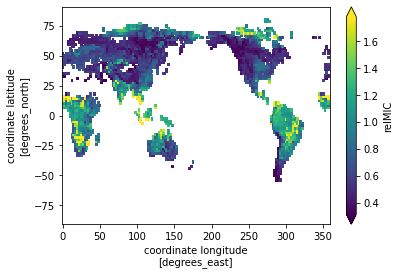

In [8]:
# QUICK LOOK AT MEAN NEP, 1901-1920, converted to gC/m2/y
(MIMcnANN.relMIC.isel(time=slice(0,20)).mean(dim='time')).plot(robust=True);
print('mean MICc:SOMc '+str(
    (MIMcnANN.relMIC.isel(time=0)*MIMcnANN.landarea/MIMcnANN.landarea.sum()).sum().values))

Calculate zonal means

In [9]:
zon_meanCNmim = MIMcnANN.mean(dim='lon') 
zon_meanCNcas = CAScnANN.mean(dim='lon')
zon_meanCcas = CAScANN.mean(dim='lon') 
zon_meanCmim = MIMcANN.mean(dim='lon') 

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

# Read observations:
- Microbial C and C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

In [10]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
#dsXu.CN100cm.plot(robust=True);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')
print('max soil C:N '+str(GSDEoc['CNmean'].max().values))
#mask out silly values
GSDEoc['CNmean2'] = GSDEoc['CNmean'].where(GSDEoc['CNmean']<150)

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )
#dims = time, lev, lat, lon gC/m2/y

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
zon_stdOBS = dsOBS.std(dim='lon') * 1000 #gC/m2
print('')
print('-- read in observed data -- ')
#dsNCSCD.NCSCD_SOC

max soil C:N 5353.0

-- read in observed data -- 


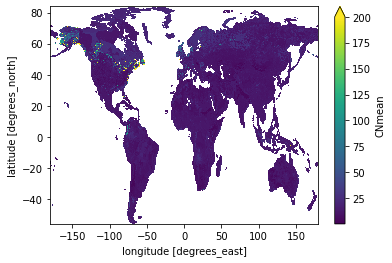

In [11]:
GSDEoc['CNmean'].plot(vmax=200);
#CNtemp = xr.concat([GSDEoc['CNmean'],GSDEoc['CNmean2']],'soilCN')
#print(CNtemp)
#simple = CNtemp.plot(col="soilCN", col_wrap=2,robust=True);

### Plot zonal means for models and observations

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwiede

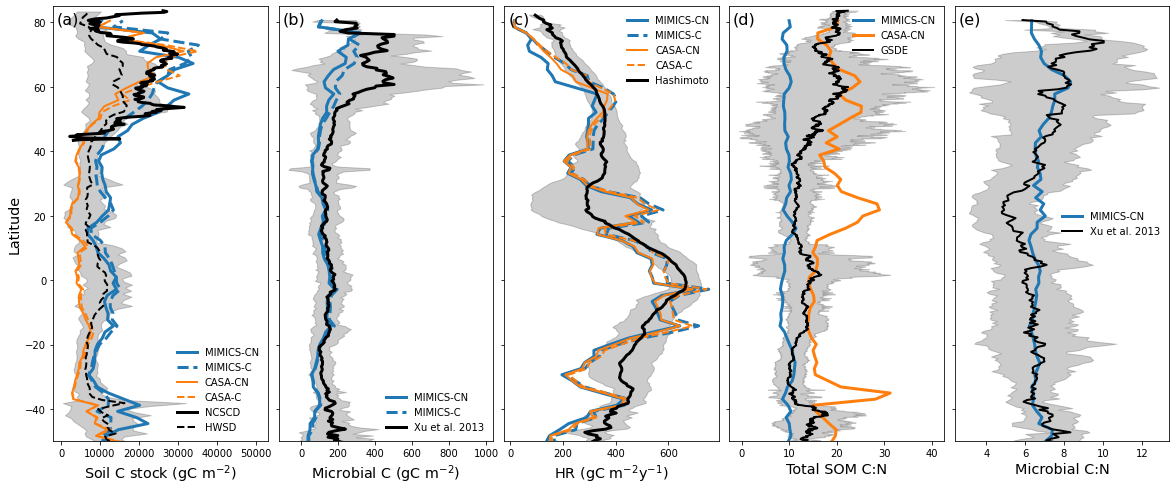

In [50]:
tPlot = 0  #time period to plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

# SOC
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','NCSCD','HWSD']
ax1.plot(zon_meanCNmim.get('cTOT').isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax1.plot(zon_meanCmim.get('cTOT').isel(time=tPlot),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax1.plot(zon_meanCNcas.get('cTOT').isel(time=tPlot), zon_meanCNcas.lat,lw=2,color=color[1],linestyle=linestyle[0])
ax1.plot(zon_meanCcas.get('cTOT').isel(time=tPlot), zon_meanCcas.lat,  lw=2,color=color[1],linestyle=linestyle[1])
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.fill_betweenx(zon_meanOBS.lat,
                  zon_meanOBS.get('HWSD_SOCall') + zon_stdOBS.get('HWSD_SOCall'), 
                  zon_meanOBS.get('HWSD_SOCall') - zon_stdOBS.get('HWSD_SOCall'),
                  alpha=0.2, color='k')

ax1.set_xlabel('Soil C stock (gC $\mathregular{m^{-2}}$)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)
ax1.set_ylim(-50, 85)

# MICc
v = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax2.plot(zon_meanCNmim.get(v).isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(zon_meanCmim.get(v).isel(time=tPlot), zon_meanCmim.lat,lw=3,color=color[0],linestyle=linestyle[1])
ax2.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=3, color='k')
ax2.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.SMC100cm.mean(dim='lon') + dsXu.SMC100cm.std(dim='lon'), 
                  dsXu.SMC100cm.mean(dim='lon') - dsXu.SMC100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax2.set_xlabel('Microbial C (gC $\mathregular{m^{-2}}$)', fontsize='x-large');
labels = ['MIMICS-CN','MIMICS-C','Xu et al. 2013']
ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# HR
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','Hashimoto']
ax3.plot(zon_meanCNmim.get('cresp').isel(time=tPlot)*365, zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCmim.get('cresp').isel(time=tPlot)*365,  zon_meanCmim.lat,  lw=3,color=color[0],linestyle=linestyle[1])
ax3.plot(zon_meanCNcas.get('cresp').isel(time=tPlot)*365, zon_meanCNcas.lat, lw=2,color=color[1],linestyle=linestyle[0])
ax3.plot(zon_meanCcas.get('cresp').isel(time=tPlot)*365, zon_meanCcas.lat, lw=2,color=color[1],linestyle=linestyle[1])
#ax3.plot(zon_meanCNmim.get('cnpp').isel(time=tPlot)*365, zon_meanCNmim.lat, lw=2,color='red',linestyle=linestyle[0])
ax3.plot(dsHR.co2.isel(time=-1,lev=0).mean(dim='lon'), dsHR.lat,lw=3, color='k')
ax3.fill_betweenx(dsHR.lat,   #add SD by lat
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') + dsHR.co2.isel(time=-1,lev=0).std(dim='lon'), 
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') - dsHR.co2.isel(time=-1,lev=0).std(dim='lon'),
                  alpha=0.2, color='k')
ax3.set_xlabel('HR (gC $\mathregular{m^{-2 } y^{-1}}$)', fontsize='x-large')
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# Soil C:N
labels = ['MIMICS-CN','CASA-CN','GSDE']
v ='cnTOT' #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax4.plot(zon_meanCNmim.get(v).isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(zon_meanCNcas.get(v).isel(time=tPlot), zon_meanCmim.lat,lw=3,color=color[1],linestyle=linestyle[0])
ax4.plot(GSDEoc['CNmean2'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
#ax4.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='r')
ax4.fill_betweenx(GSDEoc.lat,   #add SD by lat
                  GSDEoc['CNmean2'].mean(dim='lon') + GSDEoc['CNmean2'].std(dim='lon'), 
                  GSDEoc['CNmean2'].mean(dim='lon') - GSDEoc['CNmean2'].std(dim='lon'),
                  alpha=0.2, color='k')
ax4.set_xlabel('Total SOM C:N', fontsize='x-large');
ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=0)

# MIC C:N
v5 = 'cnMIC' # 'cnLIT',cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax5.plot(zon_meanCNmim.get(v5).isel(time=tPlot), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
#ax5.plot(zon_meanCNcas.get(v5).isel(time=tPlot), zon_meanCmim.lat,  lw=3,color=color[1],linestyle=linestyle[0])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.CN100cm.mean(dim='lon') + dsXu.CN100cm.std(dim='lon'), 
                  dsXu.CN100cm.mean(dim='lon') - dsXu.CN100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax5.set_xlabel('Microbial C:N', fontsize='x-large');
labels = ['MIMICS-CN','Xu et al. 2013']
ax5.legend(labels=labels, frameon = False, fontsize='medium',loc=0);

# add panel labels
ax1.annotate(panel[0], xy=(0.07, 0.97), xycoords=ax1.transAxes, ha='center', va='center',fontsize=16)    
ax2.annotate(panel[1], xy=(0.07, 0.97), xycoords=ax2.transAxes, ha='center', va='center',fontsize=16)    
ax3.annotate(panel[2], xy=(0.07, 0.97), xycoords=ax3.transAxes, ha='center', va='center',fontsize=16)    
ax4.annotate(panel[3], xy=(0.07, 0.97), xycoords=ax4.transAxes, ha='center', va='center',fontsize=16)    
ax5.annotate(panel[4], xy=(0.07, 0.97), xycoords=ax5.transAxes, ha='center', va='center',fontsize=16);    

plt.savefig(path+MIMsimCN+'/figs/'+MIMsimCN+'_Fig_1_ZonalSOM.pdf')


**Figure 1.** Zonal mean plots for MIMICS and CASA simulations (blue and orange lines, respectively) with coupled CN biogeochemistry and C-only configuration (solid and dashed lines, respectively) and relevant observations, (black lines with grey shading showing +/- 1 sigma of mean). Panels show (a) initial soil C stocks (gC m-2, 0-100 cm depth), (b) soil microbial biomass C stocks (gC m-2, 0-100 cm depth), (c) soil heterotrophic respiration fluxes (gC m-2 y-1),  (d) soil organic matter C:N ratio, and (e) microbial biomass C:N ratios.  See text for references of observations used in this analysis.

- Models show good agreement of stocks & fluxes 
- MIMICS-cn shows weak latitudal variation in soil and microbial C:N. CASA captures is because it uses a pft defined soil C:N

## TODO, used code below to write out table of global means?
- Table 1: Initial stocks & fluxes (1901-1920 means)
- Table 2: Change in global stocks and fluxes (mean 2000-2014)
GPP, NPP, HR, Soil C, microbial biomass, MIC:SOM, SOM C:N, microbial C:N

In [13]:
def globalSum ( varIn, area=MIMcnANN.landarea *1e6, timeC=1, conversion=1e-15, units=None, pt=False):
    "Global weighted sum of fluxes & states"
    temp = varIn * area 
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

def globalMean ( varIn, area=MIMcnANN.landarea *1e6, timeC=1, conversion=1, units=None, pt=False):
    "Global weighted mean"
    temp = varIn * area / area.sum()
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

d2y = 365
#MIMcnANN['cgpp'].isel(time=slice(0,20)).mean('time')
print(np.round(globalSum(MIMcnANN['cgpp'].isel(time=slice(0,20)).mean('time'),timeC=d2y, pt=False),1).values)

106.1


In [14]:
row_names = ['cgpp','cnpp','cresp','cTOT','cMICtot','relMIC','nNetMineralization','cnTOT','cnMIC']
data_in = [MIMcnANN,MIMcANN,CAScnANN,CAScANN]
col_names = ['MIMcn','MIMc','CAScn','CASc']
nrow = len(row_names)
ncol = len(col_names)
init_table = np.empty((nrow,ncol))
fin_table = np.empty((nrow,ncol))

for i in range(ncol):
    for j in range(nrow):
        din = data_in[i].isel(time=slice(0,20)).mean('time') 
        din2 = data_in[i].isel(time=slice(-20,None)).mean('time') 
        #convert fluxes appropriately
        if j <=2:
            init_table[j,i] = np.round(globalSum(din[row_names[j]],timeC=d2y, pt=False),1).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],timeC=d2y, pt=False),1).values 
        # soil C stocks
        if j == 3:
            init_table[j,i] = np.round(globalSum(din[row_names[j]],pt=False),0).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],pt=False),0).values
        # MIC C stocks, Pg C
        if j == 4 :
            if i <= 1:
                init_table[j,i] = np.round(globalSum(din[row_names[j]],pt=False),1).values
                fin_table[j,i] = np.round(globalSum(din2[row_names[j]],pt=False),1).values
            else: 
                init_table[j,i] = np.nan
                fin_table[j,i] = np.nan                
        if j == 5 :
            if i <= 1:
                init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),3).values
                fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),3).values
            else: 
                init_table[j,i] = np.nan
                fin_table[j,i] = np.nan                

        # net Mineraliztion, Tg N / year
        if j == 6 :
            if i == 0 or i == 2 :
                init_table[j,i] = np.round(globalSum(din[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values
                fin_table[j,i] = np.round(globalSum(din2[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values
            else: 
                init_table[j,i] = np.nan                
                fin_table[j,i] = np.nan                

        # soil C:N
        if j == 7 :
            if i == 0 or i == 2 :
                init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),1).values
                fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),1).values
            else: 
                fin_table[j,i] = np.nan                
                init_table[j,i] = np.nan                
        # MIC C:N
        if j == 8 :
            if i == 0 :
                init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),1).values
                fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),1).values
            else:
                init_table[j,i] = np.nan                
                fin_table[j,i] = np.nan                

change_table = fin_table - init_table
percent_table = 100* fin_table / init_table - 100
print('initial state')
print(pd.DataFrame(init_table,  index=row_names, columns=col_names))
print('Change by 2014')
print(pd.DataFrame(change_table,  index=row_names, columns=col_names))
pd.DataFrame(percent_table,  index=row_names, columns=col_names)

initial state
                      MIMcn      MIMc  CAScn   CASc
cgpp                 106.10   106.100  106.1  106.1
cnpp                  37.30    42.000   38.9   42.0
cresp                 37.30    42.000   38.9   42.0
cTOT                1713.00  1582.000  885.0  997.0
cMICtot               13.00    14.800    NaN    NaN
relMIC                 0.84     0.925    NaN    NaN
nNetMineralization   853.00       NaN  887.0    NaN
cnTOT                  9.40       NaN   18.9    NaN
cnMIC                  6.80       NaN    NaN    NaN
Change by 2014
                      MIMcn    MIMc  CAScn  CASc
cgpp                 15.500  15.500   15.5  15.5
cnpp                  5.200   5.600    5.1   5.6
cresp                 4.800   5.700    4.5   4.9
cTOT                  1.000 -24.000    6.0   6.0
cMICtot               0.800   1.200    NaN   NaN
relMIC                0.051   0.077    NaN   NaN
nNetMineralization  108.000     NaN  107.0   NaN
cnTOT                 0.000     NaN   -0.1   NaN
cnMIC     

,MIMcn,MIMc,CAScn,CASc
cgpp,14.608860,14.608860,14.608860,14.608860
cnpp,13.941019,13.333333,13.110540,13.333333
cresp,12.868633,13.571429,11.568123,11.666667
cTOT,0.058377,-1.517067,0.677966,0.601805
cMICtot,6.153846,8.108108,NaN,NaN
relMIC,6.071429,8.324324,NaN,NaN
nNetMineralization,12.661196,NaN,12.063134,NaN
cnTOT,0.000000,NaN,-0.529101,NaN
cnMIC,0.000000,NaN,NaN,NaN


In [15]:
pd.DataFrame(init_table,  index=row_names, columns=col_names).to_excel("Table1.xlsx")  
pd.DataFrame(change_table,  index=row_names, columns=col_names).to_excel("Table2.xlsx")  

In [16]:
print('MIMICS cn')
globalSum(MIMcnANN['cgpp'].isel(time=0),timeC=d2y, pt=True)
globalSum(MIMcnANN['cnpp'].isel(time=0),timeC=d2y, pt=True)
globalSum(MIMcnANN['cTOT'].isel(time=0), pt=True);
globalSum(MIMcnANN['cTOT'].isel(time=1), pt=True);
globalSum(MIMcnANN['cECO'].isel(time=0), pt=True);
globalSum(MIMcnANN['cresp'].isel(time=0), timeC=d2y, pt=True);
globalSum(MIMcnANN['cresp'].isel(time=1), timeC=d2y, pt=True);
globalSum(MIMcnANN['cMICtot'].isel(time=0), pt=True);
globalSum(MIMcnANN['cMICtot'].isel(time=-1), pt=True);
#print(MIMcnANN)

print('MIMICS Conly')
globalSum(MIMcANN['cTOT'].isel(time=0), pt=True);

print('CASA cn')
globalSum(CAScnANN['cTOT'].isel(time=0), pt=True);
print('CASA Conly')
globalSum(CAScANN['cTOT'].isel(time=0), pt=True);


globalSum(CAScANN['cnpp'].isel(time=-1),timeC=d2y, pt=False) / \
  globalSum(CAScANN['cgpp'].isel(time=-1),timeC=d2y, pt=False)


MIMICS cn
gross primary production 105.1 Pg C
net primary production 36.0 Pg C
total soil C 1714.0 Pg C
total soil C 1713.4 Pg C
total ecosystem C 2016.0 Pg C
soil heterotrophic respiration 37.8 Pg C
soil heterotrophic respiration 37.2 Pg C
sum of MIC pools 13.0 Pg C
sum of MIC pools 13.8 Pg C
MIMICS Conly
total soil C 1584.1 Pg C
CASA cn
total soil C 885.7 Pg C
CASA Conly
total soil C 997.6 Pg C


<xarray.DataArray ()>
array(0.39396633)
Coordinates:
    time     float32 2014.5013

### Look at changes over historical period

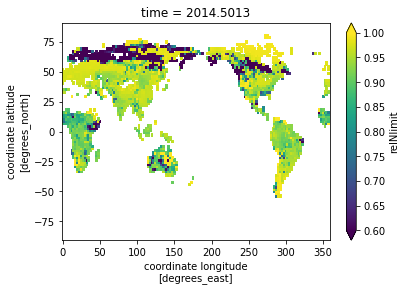

In [17]:
MIMcnANN['Nlimit'] = MIMcANN['cnpp'] - MIMcnANN['cnpp']
CAScnANN['Nlimit'] = CAScANN['cnpp'] - CAScnANN['cnpp']
MIMcnANN['relNlimit'] = MIMcnANN['cnpp'] / MIMcANN['cnpp']
CAScnANN['relNlimit'] = CAScnANN['cnpp'] / CAScANN['cnpp']

MIMcnANN['Nlimit'].attrs['long_name'] = 'N limitation of NPP'
MIMcnANN['Nlimit'].attrs['units'] = MIMcnANN['cnpp'].attrs['units']

CAScnANN['Nlimit'].attrs['long_name'] = 'N limitation of NPP'
CAScnANN['Nlimit'].attrs['units'] = CAScnANN['cnpp'].attrs['units']

MIMcnANN['relNlimit'].isel(time=-1).plot(vmax=0.6,vmin=1.);

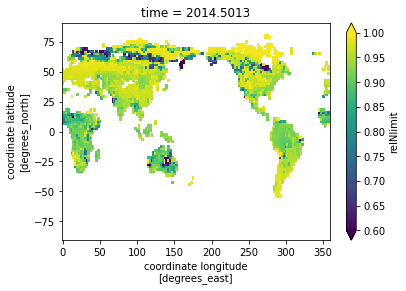

In [18]:
CAScnANN['relNlimit'].isel(time=-1).plot(vmax=0.6,vmin=1.);

['NEP']


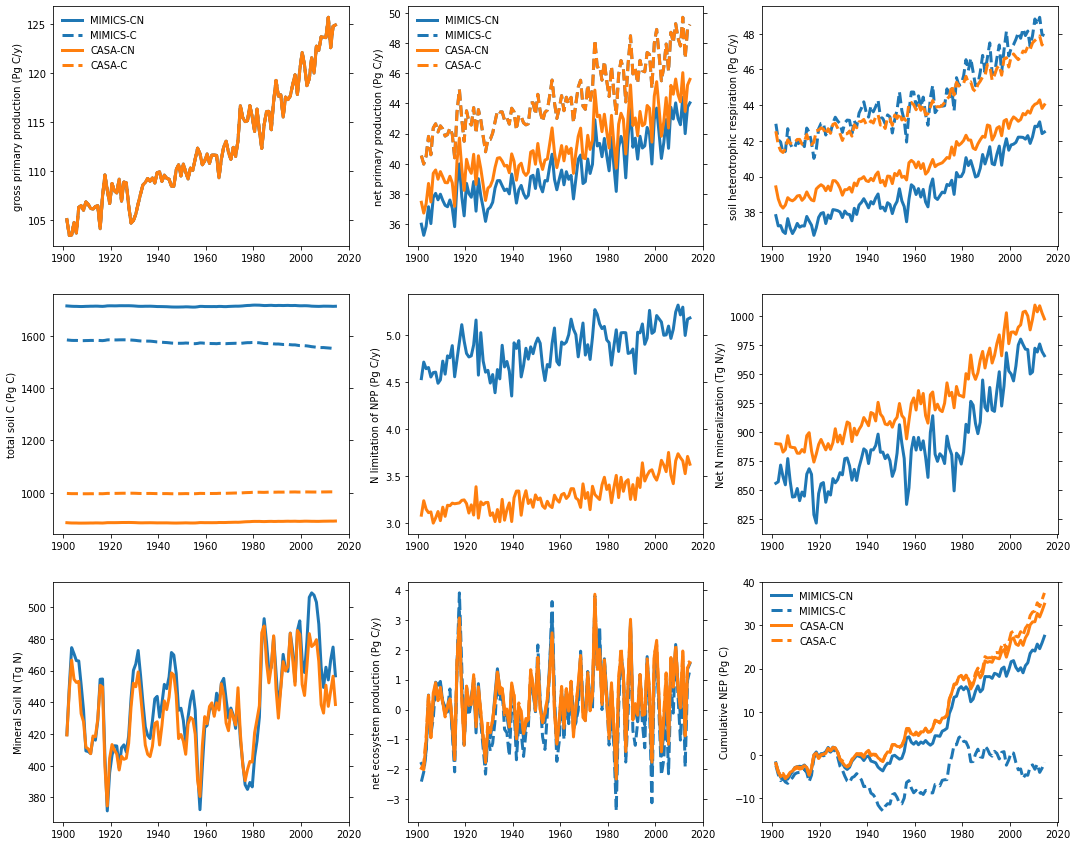

In [19]:
model = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C']
var = ['cgpp','cnpp','cresp','cTOT','Nlimit',
       'nNetMineralization','nMineral','NEP']

nvar  = len(var)
timeC = [365,365,365,1,365,
         365,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,
              1e-12,1e-12,1e-15]
units = ['(Pg C/y)','(Pg C/y)','(Pg C/y)','(Pg C)','(Pg C/y)',
         '(Tg N/y)','(Tg N)','(Pg C/y)']

fig = plt.figure(figsize=[18,15])
        
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(MIMcnANN[var[i]].attrs['long_name']+' '+units[i])
    ax.plot(MIMcnANN.time, globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]), 
             lw=3,color=color[0],linestyle=linestyle[0])
    if (i<=3) | (i>=7): 
        ax.plot(MIMcANN.time, globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion= conversion[i]), 
             lw=3,color=color[0],linestyle=linestyle[1])

    ax.plot(CAScnANN.time, globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]), 
             lw=3,color=color[1],linestyle=linestyle[0])
    if (i<=3) | (i>=7): 
        ax.plot(CAScANN.time, globalSum(CAScANN[var[i]],timeC=timeC[i],conversion= conversion[i]), 
             lw=3,color=color[1],linestyle=linestyle[1])
        
    if i<2:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
print([var[i]])
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
ax.plot(MIMcnANN.time, np.cumsum(globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[0])
ax.plot(MIMcANN.time, np.cumsum(globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[1])
ax.plot(CAScnANN.time, np.cumsum(globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[0])
ax.plot(CAScANN.time, np.cumsum(globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[1])
ax.legend(labels=model, frameon = False, fontsize='medium');


**Figure X** trends in ecosystem C & N fluxes and pools over the historical period simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Both N models have a higher cumulative NEP, but changes w/ MIMICS-CN are greater.
- Implies longer MRT of soil C pools in CN models, relative to their C-only counterparts 
- **OR** larger increases in NPP from regions experiencing N limitation (relative to the C only model). 
- From change time series below, seems like the biggest differences are in HR (not NPP)

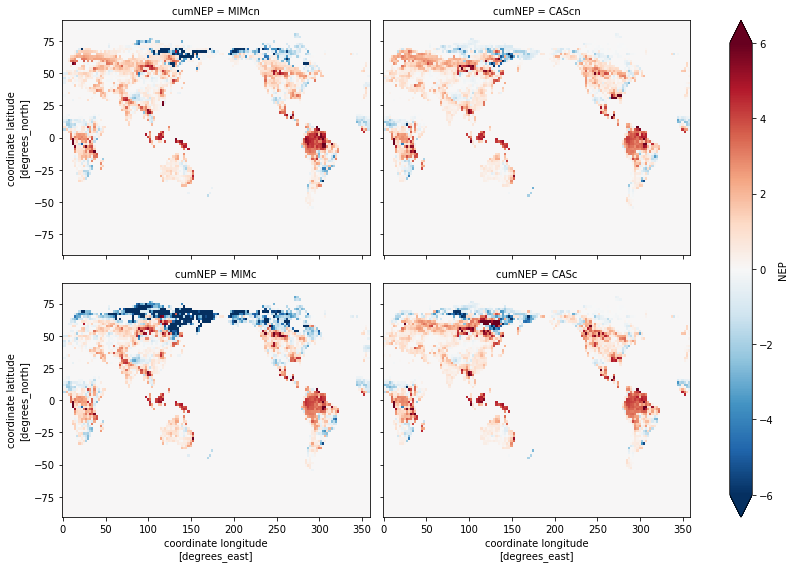

In [20]:
cumMIMcn = MIMcnANN['NEP'].cumsum(dim='time').isel(time=-1)
cumCAScn = CAScnANN['NEP'].cumsum(dim='time').isel(time=-1)
cumMIMc = MIMcANN['NEP'].cumsum(dim='time').isel(time=-1)
cumCASc = CAScANN['NEP'].cumsum(dim='time').isel(time=-1)
cumNEP = xr.concat([cumMIMcn,cumCAScn,cumMIMc,cumCASc], 'cumNEP')
cumNEP['cumNEP'] = ['MIMcn','CAScn','MIMc','CASc']
g_simple = cumNEP.plot(x="lon", y="lat", col="cumNEP", vmax=6, vmin=-6,figsize=[12,8],col_wrap=2,cmap="RdBu_r")


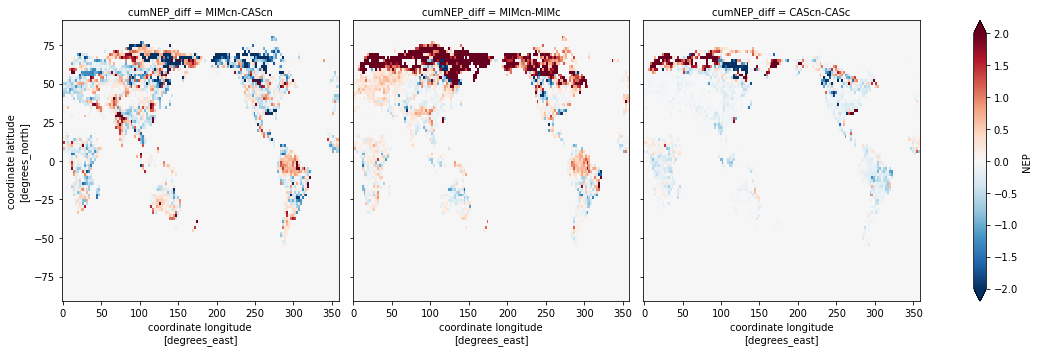

In [21]:
#Differences in NEP CN-Conly
MIMcn_CAScn =(MIMcnANN['NEP'].cumsum(dim='time')-CAScnANN['NEP'].cumsum(dim='time'))
MIMcn_MIMc = (MIMcnANN['NEP'].cumsum(dim='time')-MIMcANN['NEP'].cumsum(dim='time'))
CAScn_CASc =(CAScnANN['NEP'].cumsum(dim='time')-CAScANN['NEP'].cumsum(dim='time'))

cn_c = xr.concat([MIMcn_CAScn,MIMcn_MIMc,CAScn_CASc], 'cumNEP_diff')
cn_c['cumNEP_diff'] = ['MIMcn-CAScn','MIMcn-MIMc','CAScn-CASc']
g_simple = cn_c.isel(time=-1).plot(x="lon", y="lat", col="cumNEP_diff", vmax=2, vmin=-2,col_wrap=3,figsize=[16,5],cmap="RdBu_r")


**Figure y** N effects on cumulative NEP (1901-2014) 
- MIMICS with less net land uptake than CASA (left) 
- Biggest differences in cumulative NEP in MIMICS across arctic and boreal forests (middle), 
- CASA effects of N limitation on cumulative land C uptake are weaker (right) 

Are changes  really just reflecting the degree of initial N limitation in CN models?

['NEP']


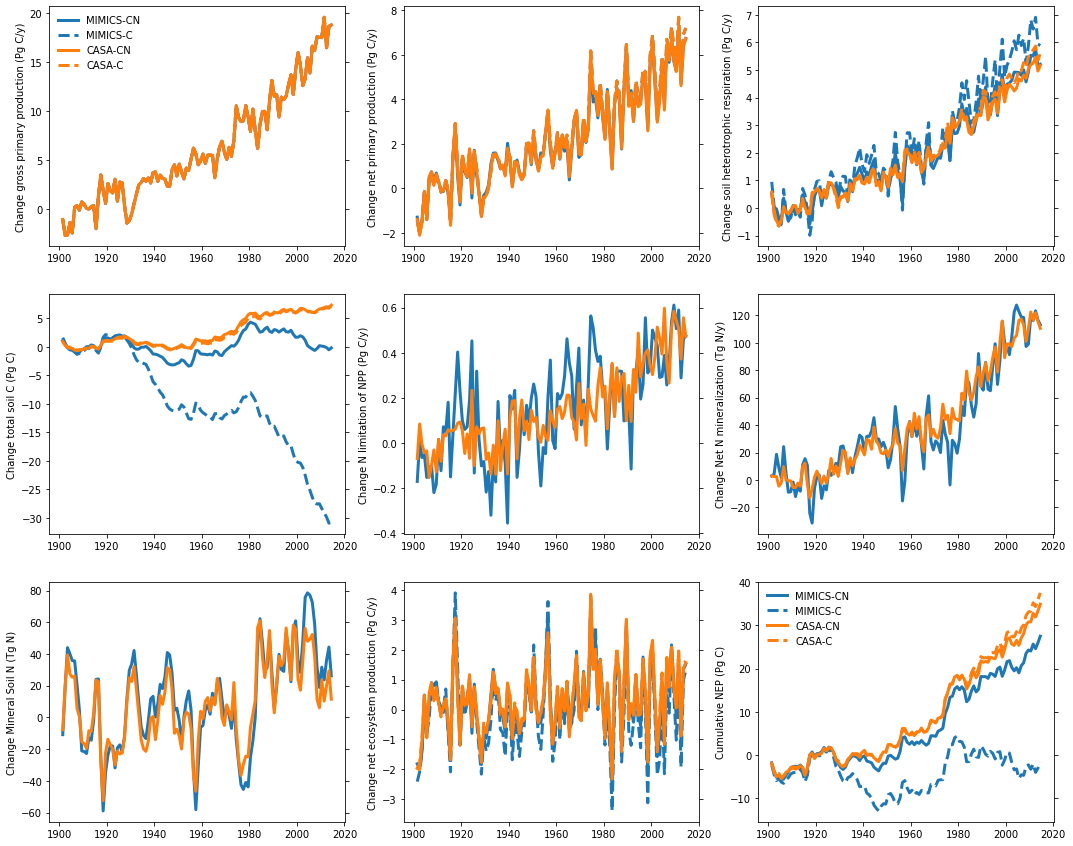

In [22]:
fig = plt.figure(figsize=[18,15]);
t = 20
    
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    ax.set_ylabel('Change '+MIMcnANN[var[i]].attrs['long_name']+' '+units[i])
    ax.plot(daMIMcn.time, (daMIMcn-daMIMcn.isel(time=slice(0,t)).mean()),
             lw=3,color=color[0],linestyle=linestyle[0]) 
    if (i<=3) | (i==7): 
        daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
        ax.plot(daMIMc.time, (daMIMc-daMIMc.isel(time=slice(0,t)).mean()), 
                 lw=3,color=color[0],linestyle=linestyle[1]) 

    ax.plot(daCAScn.time,(daCAScn-daCAScn.isel(time=slice(0,t)).mean()), 
             lw=3,color=color[1],linestyle=linestyle[0]) 
    if (i<=3) | (i==7): 
        daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])
        ax.plot(daCASc.time, (daCASc-daCASc.isel(time=slice(0,t)).mean()), 
                 lw=3,color=color[1],linestyle=linestyle[1])         
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax=fig.add_subplot(3, 3, 9)
i = 7  
print([var[i]])
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
ax.plot(MIMcnANN.time, np.cumsum(globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[0])
ax.plot(MIMcANN.time, np.cumsum(globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[1])
ax.plot(CAScnANN.time, np.cumsum(globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[0])
ax.plot(CAScANN.time, np.cumsum(globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[1])
ax.legend(labels=model, frameon = False, fontsize='medium');


**Figure X** Changes in ecosystem C & N fluxes and pools, relative to initial conditions, over the historical period 
simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only 
configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Does this influence N limitation in regions where SOM turnover is accelerating?
- Greater IAV of C&N fluxes from MIMICS, it would be interesting to see the source & driver of this variability (temp, moisture, productivity).

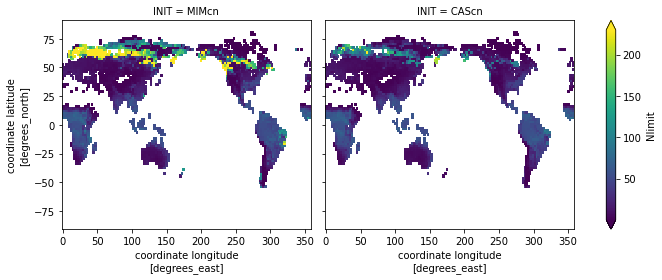

In [23]:
# Initial N limitation 
INIT = xr.concat([MIMcnANN['Nlimit'].isel(time=slice(0,20)).mean(dim='time')*365,
                  CAScnANN['Nlimit'].isel(time=slice(0,20)).mean(dim='time')*365], 'INIT')
INIT['INIT'] = ['MIMcn','CAScn']
g_simple = INIT.plot(x="lon", y="lat", col="INIT", col_wrap=2,figsize=[10,4],robust=True)
#                     vmax=35,vmin=-35);
#MIMcnANN['Nlimit'].isel(time=-1).plot();

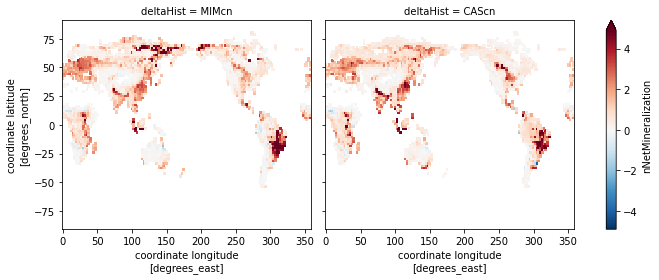

In [24]:
# look at spatial maps of changes in N limitation 1995:2014 mean - 1901:1920 mean
deltaMIMcn = MIMcnANN.isel(time=slice(-20,None)).mean(dim='time') - \
             MIMcnANN.isel(time=slice(0,20)).mean(dim='time') 
deltaCAScn = CAScnANN.isel(time=slice(-20,None)).mean(dim='time') - \
             CAScnANN.isel(time=slice(0,20)).mean(dim='time') 
# Concat files for simple plotting, 
plotVar = ['nNetMineralization','Nlimit','cnpp','cTOT']
dHist = xr.concat([deltaMIMcn[plotVar],deltaCAScn[plotVar]], 'deltaHist')

# Convert daily mean difference in fluxes to gC/m2/y
for i in range(3):
    dHist[plotVar[i]] = dHist[plotVar[i]] * 365
dHist['deltaHist'] = ['MIMcn','CAScn']
g_simple = (dHist[plotVar[0]]).plot(x="lon", y="lat", col="deltaHist", col_wrap=2,figsize=[10,4],cmap="RdBu_r", robust=True);

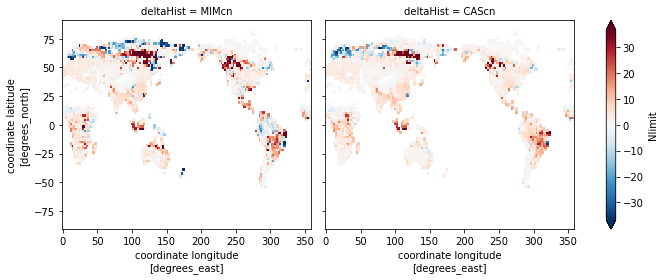

In [25]:
g_simple = dHist[plotVar[1]].plot(x="lon", y="lat", col="deltaHist", col_wrap=2,figsize=[10,4],cmap="RdBu_r", robust=True)

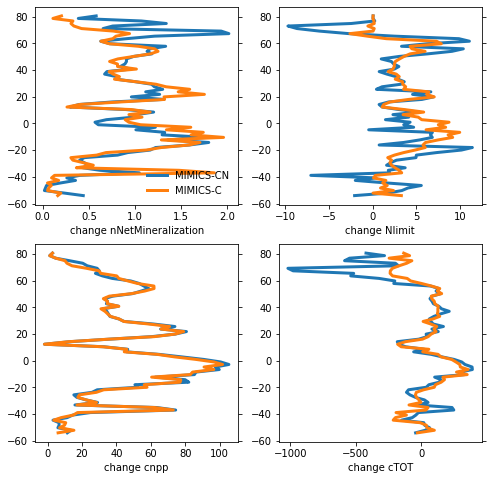

In [26]:
#dHist.mean(dim='lon').isel(deltaHist=i)
fig = plt.figure(figsize=[8,8]);
t = 20
    
for i in range(len(plotVar)):
    ax = fig.add_subplot(2, 2, (i+1))
    for j in range(2):
        ax.plot(dHist[plotVar[i]].mean(dim='lon').isel(deltaHist=j), dHist.lat, lw=3)#,color=color[0],linestyle=linestyle[0])
    ax.set_xlabel("change "+plotVar[i])
    ax.yaxis.set_ticks_position('both')
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')


In [27]:
# changes in total SOMc pools


['cgpp', 'cnpp', 'cresp', 'cTOT', 'Nlimit', 'nNetMineralization', 'nMineral', 'NEP']


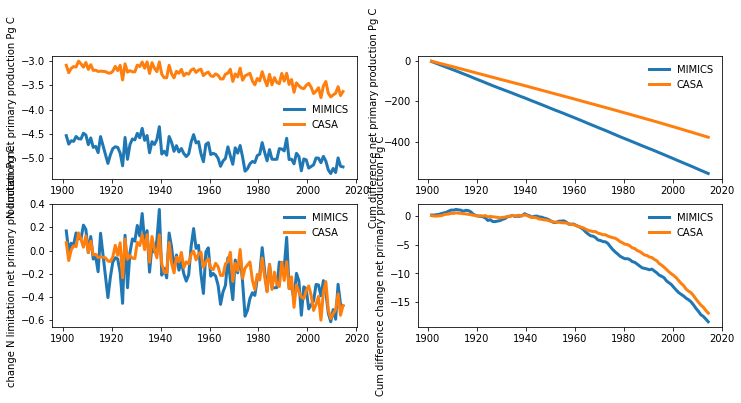

In [28]:
plt.figure(figsize=[12,5]);

i = 1
print(var)
daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])

nlimMIM = daMIMcn - daMIMc
nlimCAS = daCAScn - daCASc
delta_nlimMIM = nlimMIM-nlimMIM.isel(time=slice(0,20)).mean()
delta_nlimCAS = nlimCAS-nlimCAS.isel(time=slice(0,20)).mean()

plt.subplot(2, 2, 1)
plt.ylabel('N limitation '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
plt.plot(daMIMcn.time, nlimMIM,lw=3,color=color[0],linestyle=linestyle[0]) 
plt.plot(daCAScn.time, nlimCAS,lw=3,color=color[1],linestyle=linestyle[0])
plt.legend(labels=['MIMICS','CASA'], frameon = False, fontsize='medium')

plt.subplot(2, 2, 2)
plt.ylabel('Cum difference '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
plt.plot(daMIMcn.time, nlimMIM.cumsum(),lw=3,color=color[0],linestyle=linestyle[0]) 
plt.plot(daCAScn.time, nlimCAS.cumsum(),lw=3,color=color[1],linestyle=linestyle[0]); 
plt.legend(labels=['MIMICS','CASA'], frameon = False, fontsize='medium');

plt.subplot(2, 2, 3)
plt.ylabel('change N limitation '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
plt.plot(daMIMcn.time, delta_nlimMIM,lw=3,color=color[0],linestyle=linestyle[0]) 
plt.plot(daCAScn.time, delta_nlimCAS,lw=3,color=color[1],linestyle=linestyle[0])
plt.legend(labels=['MIMICS','CASA'], frameon = False, fontsize='medium')

plt.subplot(2, 2, 4)
plt.ylabel('Cum difference change '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
plt.plot(daMIMcn.time, delta_nlimMIM.cumsum(),lw=3,color=color[0],linestyle=linestyle[0]) 
plt.plot(daCAScn.time, delta_nlimCAS.cumsum(),lw=3,color=color[1],linestyle=linestyle[0]); 
plt.legend(labels=['MIMICS','CASA'], frameon = False, fontsize='medium');

**Fig XX** Cumulative N limitation on NPP sum(CN-Conly). Time range of initial values changes results



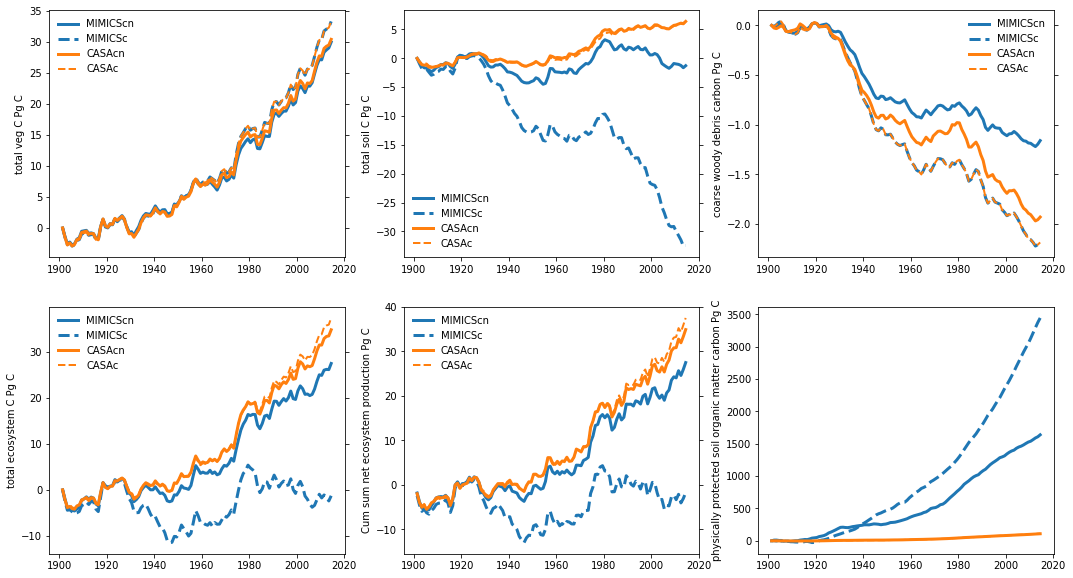

In [58]:
var = ['cVEG','cTOT','clitcwd','cECO','NEP']
timeC = [1,1,1,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15]
units = ['(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C/y)']

fig = plt.figure(figsize=[18,10]);

for i in range(len(var)):
    daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])

    ax = fig.add_subplot(2, 3, (i+1))
    if i<4:
        ax.set_ylabel(MIMcnANN[var[i]].attrs['long_name']+' Pg C')
        ax.plot(daMIMcn.time, (daMIMcn-daMIMcn.isel(time=0)),lw=3,color=color[0],linestyle=linestyle[0]) 
        ax.plot(daMIMc.time, (daMIMc-daMIMc.isel(time=0)),lw=3,color=color[0],linestyle=linestyle[1]) 
        ax.plot(daCAScn.time, (daCAScn-daCAScn.isel(time=0)),lw=3,color=color[1],linestyle=linestyle[0])
        ax.plot(daCASc.time, (daCASc-daCASc.isel(time=0)),lw=2,color=color[1],linestyle=linestyle[1])

    else:
        ax.set_ylabel('Cum sum '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
        ax.plot(daMIMcn.time, (daMIMcn.cumsum()),lw=3,color=color[0],linestyle=linestyle[0]) 
        ax.plot(daMIMc.time, (daMIMc.cumsum()),lw=3,color=color[0],linestyle=linestyle[1]) 
        ax.plot(daCAScn.time, (daCAScn.cumsum()),lw=3,color=color[1],linestyle=linestyle[0])
        ax.plot(daCASc.time, (daCASc.cumsum()),lw=2,color=color[1],linestyle=linestyle[1])
        
    ax.yaxis.set_ticks_position('both')
    plt.legend(labels=['MIMICScn','MIMICSc','CASAcn','CASAc'], frameon = False, fontsize='medium');

#Changes in SOMp
daMIMcn = globalSum(MIMcnANN['cSOMp'],timeC=timeC[i],conversion=conversion[i])
daMIMc = globalSum(MIMcANN['cSOMp'],timeC=timeC[i],conversion=conversion[i])
daCAScn = globalSum(CAScnANN['csoilpass'],timeC=timeC[i],conversion=conversion[i])
daCASc = globalSum(CAScANN['csoilpass'],timeC=timeC[i],conversion=conversion[i])
ax = fig.add_subplot(2, 3, 6)
ax.set_ylabel(MIMcnANN['cSOMp'].attrs['long_name']+' Pg C')
ax.plot(daMIMcn.time, (daMIMcn-daMIMcn.isel(time=0)),lw=3,color=color[0],linestyle=linestyle[0]) 
ax.plot(daMIMc.time, (daMIMc-daMIMc.isel(time=0)),lw=3,color=color[0],linestyle=linestyle[1]) 
ax.plot(daCAScn.time, (daCAScn-daCAScn.isel(time=0)),lw=3,color=color[1],linestyle=linestyle[0])
ax.plot(daCASc.time, (daCASc-daCASc.isel(time=0)),lw=2,color=color[1],linestyle=linestyle[1]) ;

### Plot maps of where fluxes are changing

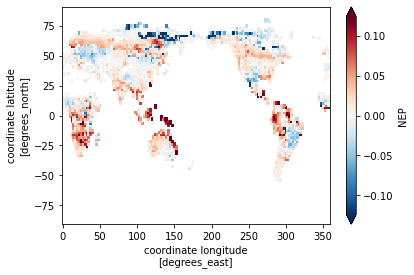

In [30]:
var='NEP'
(MIMcnANN[var].isel(time=slice(-20,None)).mean(dim='time')-
 MIMcnANN[var].isel(time=slice(  0,20  )).mean(dim='time')).plot(robust=True);

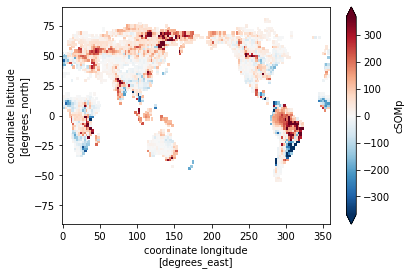

In [59]:
#print(CAScnANN)
var = ['cresp','tsoilC','nNetMineralization','cSOMp','cTOT','fW']
tempMIM = (MIMcnANN[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           MIMcnANN[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempMIM.plot(robust=True);#vmax=0.2,vmin=-0.2,cmap="RdBu_r");

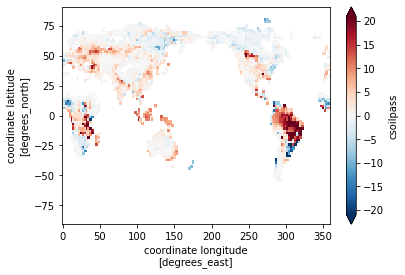

In [60]:
var = ['cresp','tsoilC','nNetMineralization','csoilpass','cTOT','fW']
tempCAS = (CAScnANN[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           CAScnANN[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempCAS.plot(robust=True)#:vmax=0.2,vmin=-0.2,cmap="RdBu_r");

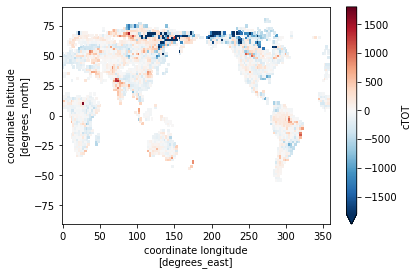

In [33]:
(tempMIM - tempCAS).plot(robust=True);
# not sure what a meaningful way to look at these changes may be?

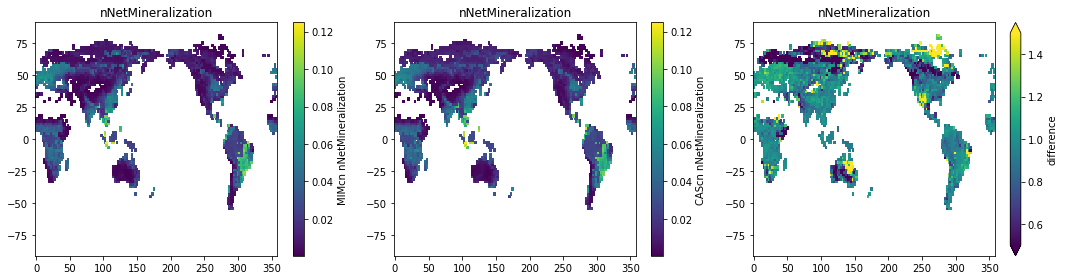

In [34]:
# ratio of respiration:mineralization over time
var = ['cresp','nNetMineralization']
MIMcnANN['HR:Min'] = (MIMcnANN[var[0]]/MIMcnANN[var[1]])
CAScnANN['HR:Min'] = (CAScnANN[var[0]]/CAScnANN[var[1]])
ncols = 3
nrows = 1
#  lists of variables, titles & labels
plotVars = ['nNetMineralization']
plotTitle = ['nNetMineralization']
plotLable = ['nNetMineralization']

# create the plots
fig = plt.figure(figsize=(15,4))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
j=0            
for ax in axes:
    if i == 0:
        MIMcnANN[plotVars[j]].isel(time=-1).plot(ax=ax, cbar_kwargs={'label': 'MIMcn '+plotLable[j]})
    if i == 1:
        CAScnANN[plotVars[j]].isel(time=-1).plot(ax=ax,  cbar_kwargs={'label': 'CAScn '+plotLable[j]})
    if i == 2:
        (MIMcnANN[plotVars[j]]/CAScnANN[plotVars[j]]).isel(time=-1).plot(
            ax=ax, vmax=1.5,vmin=0.5, cbar_kwargs={'label': 'difference'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[j])
    i = i+1

plt.tight_layout()

#MIMcnANN['HR:Min'].isel(time=0).plot(robust=True);

In [35]:
#changes in mineralization over time in both models
var2 = ['cnpp','cresp','NEP','cTOT','nNetMineralization','HR:Min','cnTOT']
#var2 = ['cnpp','cresp','NEP','cTOT']
dMIM = MIMcnANN[var2].copy('deep')
dCAS = CAScnANN[var2].copy('deep')
#dCASc = CAScANN[var2].copy('deep')
for i in range(len(var2)):
    dMIM[var2[i]] = (MIMcnANN[var2[i]]-MIMcnANN[var2[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')
    dCAS[var2[i]] = (CAScnANN[var2[i]]-CAScnANN[var2[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')
    #if i<=4:
        # dCASc[var[i]] = (CAScANN[var[i]]-CAScANN[var[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIM,dCAS],dim=model)

#model = xr.DataArray(['MIMICS-cn','CASA-cn','CASA-c'], dims='model', name='model') # or can use np.arange
#t = xr.concat([dMIM,dCAS,dCASc],dim=model)
##t['lat'] = t.lat.where(t.lat> -50)
#t

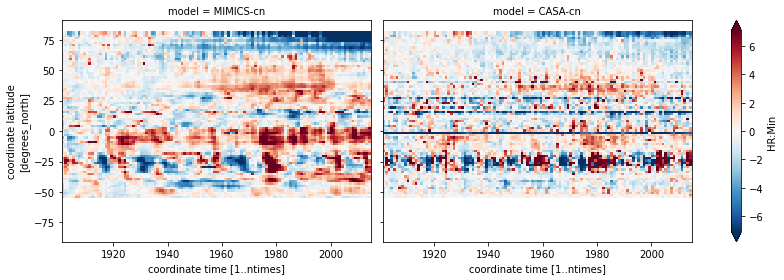

In [36]:
simple = t[var2[5]].plot(x='time', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);

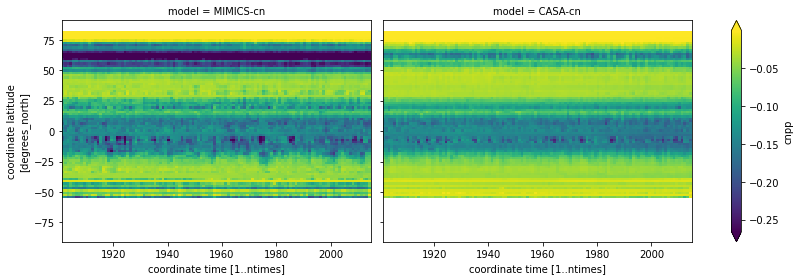

In [37]:
#changes, relative to the C-only model
var2 = ['cnpp','cresp','NEP','cTOT']
dMIM = MIMcnANN[var2].copy('deep')
dCAS = CAScnANN[var2].copy('deep')
#dCASc = CAScANN[var2].copy('deep')
for i in range(len(var2)):
    dMIM[var2[i]] = (MIMcnANN[var2[i]]-MIMcANN[var2[i]]).mean(dim='lon')
    dCAS[var2[i]] = (CAScnANN[var2[i]]-CAScANN[var2[i]]).mean(dim='lon')
    #dMIM[var[i]] = (dMIM[var[i]]-dMIM[var[i]].isel(time=slice(0,20))).mean(dim='lon')
    #dCAS[var[i]] = (dCAS[var[i]]-dCAS[var[i]].isel(time=slice(0,20))).mean(dim='lon')
    #if i<=4:
        # dCASc[var[i]] = (CAScANN[var[i]]-CAScANN[var[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIM,dCAS],dim=model)

#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t[var2[0]].plot(x='time', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);
#model = xr.DataArray(['MIMICS-cn','CASA-cn','CASA-c'], dims='model', name='model') # or can use np.arange
#t = xr.concat([dMIM,dCAS,dCASc],dim=model)
##t['lat'] = t.lat.where(t.lat> -50)
#t

**Figure X.** Zonal mean changes in N mineralization rates simulated by MIMICS-cn & CASA-cn

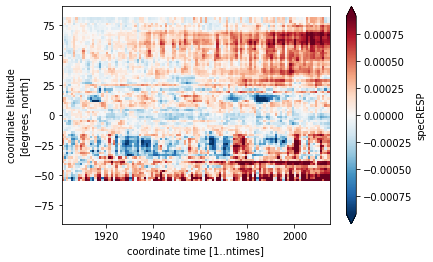

In [38]:
# look a some MIM specific results
var = ['specRESP','cMICtot','MICrK','cnMIC']
(MIMcnANN[var[0]]-MIMcnANN[var[0]].isel(time=slice(0,10)).mean(dim='time')).mean(dim='lon').plot(x='time',y='lat',robust=True);
#MIMcnANN

### Look at environmental controls over soil C:N in MIMICS

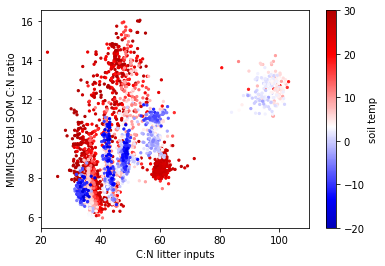

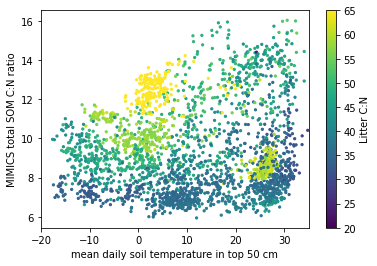

In [39]:
ds_1 = MIMcnANN.isel(time=0)
ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

color_by = ds_1.tsoilC
label = 'soil temp'  # Need to rename if 'color_by' is changed

fig, ax = plt.subplots()
s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               cmap = utils.truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = -20,            # Min value
               vmax = 30)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds_1['cnLIT'].attrs['long_name'])
plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
ax.set_xlim(20, 110)
plt.show();

color_by = ds_1['cnLIT'] 
label = 'Litter C:N'     
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
fig, ax = plt.subplots()
s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = 20,            # Min value
               vmax = 65)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds_1['tsoilC'].attrs['long_name'])
plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
ax.set_xlim(-20, 35)
plt.show();


**Figure 3** Temperature and litter stoichiometry interact to determine the soil C:N ratios that are simulated by MIMICS-CN. Points represent the gridcell mean annual stoichiometry of litterfall C:N fluxes that are simulated by the CASA-CNP vegetation model and resulting soil C:N ratios that are simulated by MIMICS.  The color of each point indicates mean annual soil temperature simulated by over the spin-up period (1901-1920). 


### Annual cycle of fluxes
This can be done for grid cells, or zonally

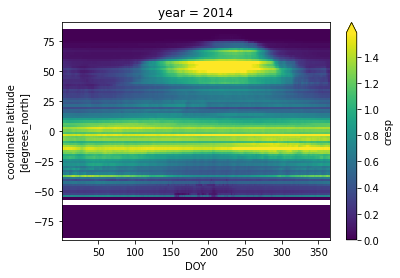

In [40]:
var = ['cMICtot','nMineral','cresp','nNetMineralization','MICrK','cnMIC','cnpp']
v = 2
MIMcn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

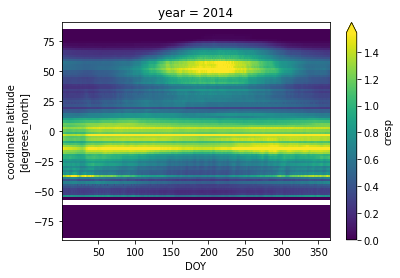

In [41]:
CAScn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

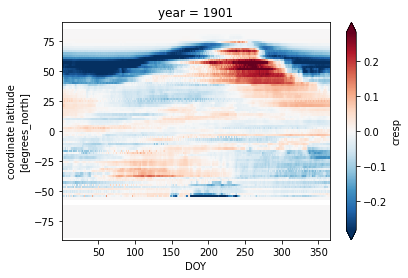

In [42]:
# Differences betweeen models (MIMICS-CASA)
v = 2
(MIMcn.isel(year=0)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(x='DOY', robust=True);

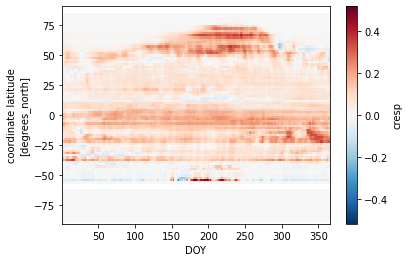

In [43]:
v = 2
(MIMcn.isel(year=1)[var[v]] - MIMcn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2);

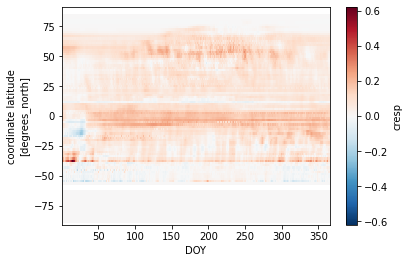

In [44]:
(CAScn.isel(year=1)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2) ;

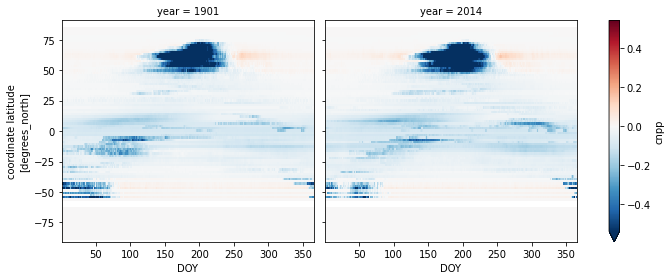

In [45]:
# how N limited are arctic systems at end of simulation in each model?
v = 6
simple = (MIMcn[var[v]]- MIMc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

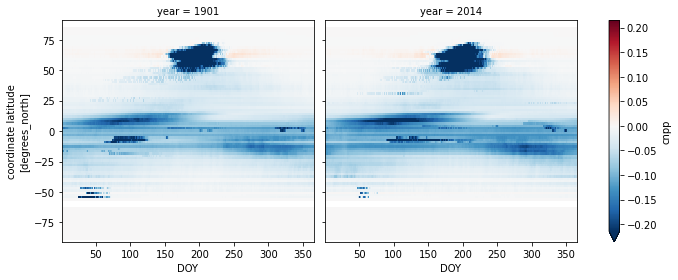

In [46]:
simple = (CAScn[var[v]]- CASc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

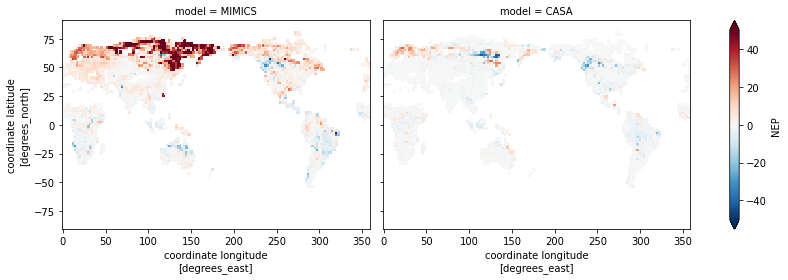

In [47]:
var = 'NEP'
Neff_mim = MIMcnANN[var]-MIMcANN[var]
Neff_cas = CAScnANN[var]-CAScANN[var]
Neff_mim = Neff_mim.isel(time=slice(-20,None)).mean(dim='time') - Neff_mim.isel(time=slice(0,20)).mean(dim='time')
Neff_cas = Neff_cas.isel(time=slice(-20,None)).mean(dim='time') - Neff_cas.isel(time=slice(0,20)).mean(dim='time')
model = xr.DataArray(['MIMICS','CASA'], dims='model', name='model') # or can use np.arange
t = xr.concat([Neff_mim,Neff_cas],dim=model)
t = t*365 #convert from gC/m2/d to gC/m2/y
#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t.plot(x='lon', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);


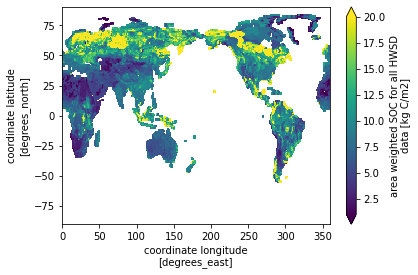

In [49]:
dsOBS['HWSD_SOCall'].plot(vmax=20,vmin=1);